# Exercise 4 Solution: Calibrate and Project an SEIR Model with Interventions (R Version)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-4/solutions/r-colab/exercise_4_seir_calibration.ipynb)

**Scenario:** An outbreak occurs in California. After some time, interventions are implemented that reduce transmission. We will:

1. Generate synthetic data from an SEIR model with an intervention (β drops mid-epidemic)
2. Calibrate the model to recover the initial β and the reduction factor
3. Project forward under different scenarios (status quo vs. relaxation)

In [1]:
!pip install epydemix
%load_ext rpy2.ipython

ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 97, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 484, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_vendor/packaging/version.py", line 56, in parse
    return Version(version)
  File "/opt/anaconda3/lib/python3.8/site-packages

In [2]:
%%R
if (!require("reticulate", quietly = TRUE)) {
  install.packages("reticulate")
}
library(reticulate)
use_python("/usr/bin/python3", required = TRUE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


## Task 1: Generate Synthetic Data

We create an SEIR model for California where:
- Initial β = 0.035 (baseline transmission)
- On day 50, interventions reduce β to 60% of original (reduction_factor = 0.6)
- The epidemic runs for 120 days total

In [3]:
%%R
# Import Python modules
epydemix <- import("epydemix")
EpiModel <- epydemix$EpiModel
simulate <- epydemix$simulate
load_epydemix_population <- epydemix$population$load_epydemix_population
builtins <- import_builtins()
np <- import("numpy")
pd <- import("pandas")
scipy_stats <- import("scipy.stats")
plt <- import("matplotlib.pyplot")

# Calibration and visualization
calib <- import("epydemix.calibration")
ABCSampler <- calib$ABCSampler
rmse <- calib$rmse
viz <- import("epydemix.visualization")
plot_quantiles <- viz$plot_quantiles
plot_posterior_distribution <- viz$plot_posterior_distribution
utils_module <- import("epydemix.utils")
compute_simulation_dates <- utils_module$compute_simulation_dates


In [4]:
%%R
# True parameters (what we'll try to recover)
TRUE_BETA <- 0.035
TRUE_REDUCTION <- 0.6  # β drops to 60% of original
INTERVENTION_DAY <- 50L

# Simulation settings
START_DATE <- "2026-01-01"
END_DATE <- "2026-04-30"  # 120 days
CALIBRATION_END <- "2026-03-15"  # Calibrate up to day 74

# Fixed disease parameters
SIGMA <- 0.2   # 5-day latent period
GAMMA <- 0.1   # 10-day infectious period

# Compute intervention date
intervention_date <- as.character(as.Date(START_DATE) + INTERVENTION_DAY)

cat(sprintf("Intervention date: %s\n", intervention_date))
cat(sprintf("β before intervention: %s\n", TRUE_BETA))
cat(sprintf("β after intervention: %s\n", TRUE_BETA * TRUE_REDUCTION))

Intervention date: 2026-02-20
β before intervention: 0.035
β after intervention: 0.021


In [5]:
%%R
# Function to create SEIR model
create_seir_model <- function(beta = TRUE_BETA) {
  model <- EpiModel(name = "SEIR", compartments = c("S", "E", "I", "R"))
  
  params_SE <- builtins$tuple(list("beta", "I"))
  model$add_transition(source = "S", target = "E", params = params_SE, kind = "mediated")
  model$add_transition(source = "E", target = "I", params = "sigma", kind = "spontaneous")
  model$add_transition(source = "I", target = "R", params = "gamma", kind = "spontaneous")
  
  model$add_parameter("beta", beta)
  model$add_parameter("sigma", SIGMA)
  model$add_parameter("gamma", GAMMA)
  
  # Load California population
  population <- load_epydemix_population("United_States_California")
  model$set_population(population)
  
  return(model)
}

# Create model and add intervention
model_truth <- create_seir_model()

# Add intervention: β drops after INTERVENTION_DAY
model_truth$override_parameter(
  start_date = intervention_date,
  end_date = END_DATE,
  parameter_name = "beta",
  value = TRUE_BETA * TRUE_REDUCTION
)

model_truth

EpiModel(name='SEIR')
Compartments: 4
  S, E, I, R
Transitions: 3
  Transitions between compartments:
    S -> E, params: ['beta', 'I'] (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
Parameters: 3
  Model parameters:
    beta: 0.035
    sigma: 0.2
    gamma: 0.1
Population: United_States_California
  Population size: 38965193 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



In [6]:
%%R
# Generate synthetic data
population <- model_truth$population
Nk_r <- py_to_r(population$Nk)
n_groups <- length(Nk_r)

# Initial conditions: seed with 1000 infected
initial_infected <- 1000L
infected_per_group <- rep(as.integer(initial_infected / n_groups), n_groups)

initial_conditions <- reticulate::dict(
  S = as.integer(Nk_r - infected_per_group),
  E = rep(0L, n_groups),
  I = infected_per_group,
  R = rep(0L, n_groups)
)

# Run one simulation to generate "observed" data
results_truth <- model_truth$run_simulations(
  start_date = START_DATE,
  end_date = END_DATE,
  Nsim = 1L,
  initial_conditions_dict = initial_conditions
)

# Extract incidence (E→I transitions)
transitions <- results_truth$get_stacked_transitions()
incidence <- py_to_r(transitions["E_to_I_total"])$E_to_I_total[1, ]  # First simulation
dates <- seq(as.Date(START_DATE), by = "day", length.out = length(incidence))

# Create data frame
data <- data.frame(date = dates, data = incidence)

cat(sprintf("Generated %d days of data\n", nrow(data)))
cat(sprintf("Peak incidence: %.0f on day %d\n", max(data$data), which.max(data$data)))

Generated 120 days of data
Peak incidence: 767444 on day 81


In [7]:
%%R
# Split into calibration and projection periods
calibration_end_date <- as.Date(CALIBRATION_END)
data_calibration <- data[data$date <= calibration_end_date, ]
data_projection <- data[data$date > calibration_end_date, ]

cat(sprintf("Calibration: %s to %s (%d days)\n",
            data_calibration$date[1], data_calibration$date[nrow(data_calibration)],
            nrow(data_calibration)))
cat(sprintf("Projection:  %s to %s (%d days)\n",
            data_projection$date[1], data_projection$date[nrow(data_projection)],
            nrow(data_projection)))

Calibration: 2026-01-01 to 2026-03-15 (74 days)
Projection:  2026-03-16 to 2026-04-30 (46 days)


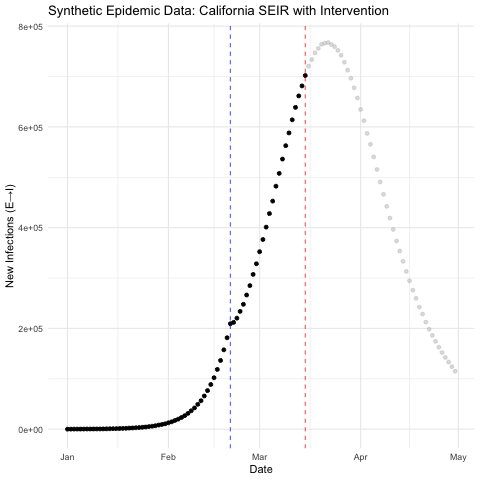

In [8]:
%%R
library(ggplot2)

# Visualize the synthetic data
ggplot() +
  geom_point(data = data_calibration, aes(x = date, y = data), color = "black", size = 1.5) +
  geom_point(data = data_projection, aes(x = date, y = data), color = "gray", alpha = 0.5, size = 1.5) +
  geom_vline(xintercept = as.numeric(as.Date(intervention_date)), color = "blue", 
             linetype = "dashed", alpha = 0.7) +
  geom_vline(xintercept = as.numeric(calibration_end_date), color = "red", 
             linetype = "dashed", alpha = 0.7) +
  labs(x = "Date", y = "New Infections (E→I)",
       title = "Synthetic Epidemic Data: California SEIR with Intervention") +
  theme_minimal()

## Task 2: Set Up the Calibration Model

We'll calibrate two parameters:
- `beta`: Initial transmission rate (before intervention)
- `reduction`: The factor by which β is reduced after the intervention

In [9]:
%%R
# Create calibration model
model_calib <- create_seir_model()

# Store end date for wrapper
OVERRIDE_END_DATE <- END_DATE

In [10]:
%%R
# Define wrapper function in Python
py_run_string('
from epydemix import simulate

def simulate_wrapper(parameters):
    """Wrapper that applies intervention and runs simulation."""
    # Extract sampled parameters
    reduction = parameters.get("reduction", 1.0)
    beta = parameters.get("beta", 0.035)
    
    # Clear previous overrides and add intervention
    parameters["epimodel"].clear_overrides()
    parameters["epimodel"].override_parameter(
        start_date=intervention_date,
        end_date=OVERRIDE_END_DATE,
        parameter_name="beta",
        value=beta * reduction
    )
    
    # Run simulation
    results = simulate(**parameters)
    
    return {"data": results.transitions["E_to_I_total"]}
')

simulate_wrapper <- py$simulate_wrapper

## Task 3: Define Priors and Run Calibration

In [11]:
%%R
# Define priors
priors <- reticulate::dict(
  beta = scipy_stats$uniform(loc = 0.02, scale = 0.025),      # U(0.02, 0.045)
  reduction = scipy_stats$uniform(loc = 0.3, scale = 0.6)     # U(0.3, 0.9)
)

cat("Prior distributions:\n")
cat("  beta: U(0.02, 0.045)\n")
cat("  reduction: U(0.3, 0.9)\n")
cat(sprintf("\nTrue values: beta=%s, reduction=%s\n", TRUE_BETA, TRUE_REDUCTION))

Prior distributions:
  beta: U(0.02, 0.045)
  reduction: U(0.3, 0.9)

True values: beta=0.035, reduction=0.6


In [12]:
%%R
# Calibration parameters
calibration_parameters <- reticulate::dict(
  initial_conditions_dict = initial_conditions,
  epimodel = model_calib,
  start_date = START_DATE,
  end_date = CALIBRATION_END
)

# Initialize ABC sampler
abc_sampler <- ABCSampler(
  simulation_function = simulate_wrapper,
  priors = priors,
  parameters = calibration_parameters,
  observed_data = data_calibration$data,
  distance_function = rmse
)

In [13]:
%%R
# Run ABC-SMC calibration
cat("Running calibration...\n")
calibration_results <- abc_sampler$calibrate(
  strategy = "smc",
  num_particles = 100L,
  num_generations = 5L
)
cat("Done!\n")

Running calibration...
Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
Error in py_call_impl(callable, call_args$unnamed, call_args$named) : 
  NameError: name 'intervention_date' is not defined
Run `reticulate::py_last_error()` for details.


RInterpreterError: Failed to parse and evaluate line '# Run ABC-SMC calibration\ncat("Running calibration...\\n")\ncalibration_results <- abc_sampler$calibrate(\n  strategy = "smc",\n  num_particles = 100L,\n  num_generations = 5L\n)\ncat("Done!\\n")\n'.
R error message: "Error in py_call_impl(callable, call_args$unnamed, call_args$named) : \n  NameError: name 'intervention_date' is not defined\nRun `reticulate::py_last_error()` for details."

In [ ]:
%%R
# Visualize posterior distributions
posterior <- calibration_results$get_posterior_distribution()

# Beta posterior
ax1 <- plot_posterior_distribution(posterior, "beta", kind = "kde", 
                                   title = "Transmission Rate (β)", color = "blue")
ax1$axvline(TRUE_BETA, color = "red", linestyle = "--", label = sprintf("True value (%s)", TRUE_BETA))
ax1$legend()
plt$show()

# Reduction posterior  
ax2 <- plot_posterior_distribution(posterior, "reduction", kind = "kde",
                                   title = "Reduction Factor", color = "orange")
ax2$axvline(TRUE_REDUCTION, color = "red", linestyle = "--", label = sprintf("True value (%s)", TRUE_REDUCTION))
ax2$legend()

In [ ]:
%%R
# Print posterior summaries
posterior_r <- py_to_r(posterior)

cat("Posterior estimates vs True values:\n")
cat(sprintf("%-12s %-10s %-20s %-10s\n", "Parameter", "Median", "IQR", "True"))
cat(strrep("-", 52), "\n")

for (param in c("beta", "reduction")) {
  true_val <- if (param == "beta") TRUE_BETA else TRUE_REDUCTION
  values <- posterior_r[[param]]
  med <- median(values)
  q25 <- quantile(values, 0.25)
  q75 <- quantile(values, 0.75)
  cat(sprintf("%-12s %-10.4f [%.4f, %.4f]   %-10.4f\n", param, med, q25, q75, true_val))
}

## Task 4: Project Under Alternative Scenarios

We'll compare two scenarios for the projection period:

1. **Status quo**: Interventions remain in place (β stays reduced)
2. **Relaxation**: Interventions are lifted (β returns to baseline)

In [ ]:
%%R
cat("Running scenario projections...\n")

# Run projections (status quo - interventions maintained)
params_status_quo <- reticulate::dict(
  initial_conditions_dict = initial_conditions,
  epimodel = model_calib,
  start_date = START_DATE,
  end_date = as.character(data_projection$date[nrow(data_projection)])
)
results_status_quo <- abc_sampler$run_projections(params_status_quo)
cat("  Status quo: done\n")

# Change OVERRIDE_END_DATE to stop intervention at calibration end
py_run_string(sprintf('OVERRIDE_END_DATE = "%s"', CALIBRATION_END))

# Run projections (relaxation - interventions lifted)
params_relaxation <- reticulate::dict(
  initial_conditions_dict = initial_conditions,
  epimodel = model_calib,
  start_date = START_DATE,
  end_date = as.character(data_projection$date[nrow(data_projection)])
)
results_relaxation <- abc_sampler$run_projections(params_relaxation)
cat("  Relaxation: done\n")

In [ ]:
%%R
# Compute projection dates
projection_dates <- compute_simulation_dates(
  start_date = START_DATE,
  end_date = as.character(data_projection$date[nrow(data_projection)])
)

# Get quantiles for plotting
df_status_quo <- results_status_quo$get_projection_quantiles(projection_dates)
df_relaxation <- results_relaxation$get_projection_quantiles(projection_dates)

# Convert data to Python DataFrame for plot_quantiles
data_py <- pd$DataFrame(reticulate::dict(
  date = as.character(data$date),
  data = data$data
))

# Plot scenario comparison
ax <- plot_quantiles(df_status_quo, columns = "data", data = data_py, 
                     colors = "blue", show_legend = FALSE, show_data = TRUE,
                     labels = list("Status Quo"))
ax <- plot_quantiles(df_relaxation, columns = "data", ax = ax,
                     colors = "orange", show_legend = FALSE, show_data = FALSE,
                     labels = list("Relaxation"))
                     
ax$legend(loc = "upper left", frameon = FALSE)
ax$set_xlabel("Date")
ax$set_ylabel("New Infections (E→I)")
ax$set_title("Scenario Projections: Impact of Intervention Policies")

plt$tight_layout()
plt$show()

## Discussion

**Key findings:**

1. **Parameter recovery**: The calibration successfully recovered the true values of β and the reduction factor, demonstrating that ABC-SMC can identify intervention effects from incidence data.

2. **Scenario projections**: The two scenarios show different outcomes:
   - **Status quo**: Continuing interventions keeps transmission reduced, leading to a controlled decline in infections
   - **Relaxation**: Lifting interventions allows β to return to baseline, resulting in higher transmission during the projection period

**Policy implications:**
- Premature relaxation of interventions can lead to increased infections
- Model projections provide a framework for comparing policy options under uncertainty
- Decision-makers can use these projections to weigh trade-offs between maintaining restrictions and relaxing them

**Limitations:**
- This exercise uses synthetic data; real-world data has additional complexities (reporting delays, changing behavior, etc.)
- We assumed known intervention timing; in practice, this may need to be estimated
- The model assumes homogeneous mixing and does not account for spatial heterogeneity